In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from feature_engine.timeseries.forecasting import LagFeatures
from sklearn.metrics import root_mean_squared_error
import pickle

pd.set_option('display.max_columns', None)

In [19]:
df = pd.read_parquet('../data/forecast/top8_arima.parquet.gzip')

In [ ]:
df.head()

163         79
0  69.667311  17.515598
1  14.705680   4.168354
2  18.647661   3.396810
3  10.723433   4.976445
4  28.922964   3.272852

In [55]:

class TemporalModels:
    def __init__(self, predictions, start_date, end_date):
        self.predictions = predictions.reset_index()
        self.start_date = start_date
        self.end_date = end_date

    def predict(self, X):
        X_tmp = X.reset_index()

        X_temporal = pd.DataFrame()
        X_temporal['year_month_day_hour'] = pd.date_range(
            start=self.start_date,
            end=self.end_date,
            freq='h'
        )

        X_temporal = X_temporal.reset_index().merge(self.predictions,
                        how='left',
                        on='index')
        
        X_temporal = X_temporal.melt(id_vars=['year_month_day_hour'], 
                    value_vars=list(set(self.predictions.columns) - set(['index', 'year_month_day_hour'])), 
                    var_name='PULocationID', 
                    value_name='qty_travels')
        
        X_temporal['PULocationID'] = X_temporal['PULocationID'].astype(int)

        X_tmp = X_tmp.merge(X_temporal,
                            how='left',
                            on=['year_month_day_hour', 'PULocationID']).sort_values(by='index', ascending=True)

        return X_tmp['qty_travels']

In [56]:
model = TemporalModels(df, start_date='2024-02-01 00', end_date='2024-02-07 23')

In [57]:
import os
df_valid = pd.read_parquet(os.path.join('../data', f'aggregated/full_valid.parquet.gzip'))
df_valid['year_month_day_hour'] = pd.to_datetime(df_valid['year_month_day_hour'], format='%Y-%m-%d %H')
df_valid['PULocationID'] = df_valid['PULocationID'].astype(int)

In [58]:
aux = model.predict(df_valid[['year_month_day_hour', 'PULocationID']])

In [5]:
def get_metrics(list_of_tuples_of_models, train_data, valid_data, target_col):
    dict_models_metrics = {
        'model' : ['Default'],
        'desc' : ['Default values mean + std'],
        'rmse_train' : [f'{train_data[target_col].mean():.2f} +- {train_data[target_col].std():.2f}'],
        'rmse_valid' : [f'{valid_data[target_col].mean():.2f} +- {valid_data[target_col].std():.2f}'],
        'diff_rmse' : [0]
    }

    for model, features, desc, train_data_, valid_data_ in list_of_tuples_of_models:
        dict_models_metrics['model'].append(model.__class__)
        dict_models_metrics['desc'].append(desc)
        (
            dict_models_metrics['rmse_train'].append(
                root_mean_squared_error(
                    train_data_[target_col],
                    np.nan_to_num(model.predict(train_data_[features]),0)
                )
            )
        )
        (
            dict_models_metrics['rmse_valid'].append(
                root_mean_squared_error(
                    valid_data_[target_col],
                    np.nan_to_num(model.predict(valid_data_[features]),0)
                )
            )
        )
        dict_models_metrics['diff_rmse'].append(
            dict_models_metrics['rmse_train'][-1] - dict_models_metrics['rmse_valid'][-1]
        )


    return pd.DataFrame(dict_models_metrics)


# Boosting

In [6]:
260*24*30*5

936000

In [7]:
df_train_lag = pd.read_parquet('../data/lag/full_train.parquet.gzip').sort_values('year_month_day_hour', ascending=True)
df_valid_lag = pd.read_parquet('../data/lag/full_valid.parquet.gzip').sort_values('year_month_day_hour', ascending=True)

In [9]:
df_train_lag.columns

Index(['year_month_day_hour', 'PULocationID', 'Maximum_max', 'Minimum_max',
       'passenger_count_sum', 'day_of_week_max', 'period_of_day_dawn_sum',
       'period_of_day_morning_sum', 'period_of_day_afternoon_sum',
       'period_of_day_evening_sum', 'qty_travels', 'year_month_day_hour_l1',
       'year_month_day_hour_l2', 'year_month_day_hour_l3', 'Maximum_max_l3',
       'Minimum_max_l3', 'passenger_count_sum_l3', 'day_of_week_max_l3',
       'period_of_day_dawn_sum_l3', 'period_of_day_morning_sum_l3',
       'period_of_day_afternoon_sum_l3', 'period_of_day_evening_sum_l3',
       'qty_travels_l3', 'Maximum_max_l2', 'Minimum_max_l2',
       'passenger_count_sum_l2', 'day_of_week_max_l2',
       'period_of_day_dawn_sum_l2', 'period_of_day_morning_sum_l2',
       'period_of_day_afternoon_sum_l2', 'period_of_day_evening_sum_l2',
       'qty_travels_l2', 'Maximum_max_l1', 'Minimum_max_l1',
       'passenger_count_sum_l1', 'day_of_week_max_l1',
       'period_of_day_dawn_sum_l1', 'peri

In [13]:
aux = df_train_lag.PULocationID.value_counts()

In [20]:
aux[aux >= 744].index

Index([163, 79, 100, 140, 107, 186, 48, 132], dtype='int32', name='PULocationID')

In [3]:
df_train_lag.head()

year_month_day_hour  PULocationID  Maximum_max  Minimum_max  \
0         2024-01-01 00             4         45.0         32.0   
99        2024-01-01 00           179         45.0         32.0   
100       2024-01-01 00           180         45.0         32.0   
101       2024-01-01 00           181         45.0         32.0   
102       2024-01-01 00           186         45.0         32.0   

     passenger_count_sum  day_of_week_max  period_of_day_dawn_sum  \
0                   27.0                0                      25   
99                   1.0                0                       6   
100                  0.0                0                       1   
101                  7.0                0                       6   
102                134.0                0                     102   

     period_of_day_morning_sum  period_of_day_afternoon_sum  \
0                            0                            0   
99                           0                            0   
100                          0                            0   
101                          0                            0   
102                          0                            0   

     period_of_day_evening_sum  qty_travels year_month_day_hour_l1  \
0                            0          4.0          2023-12-31 23   
99                           0          1.0          2023-12-31 23   
100                          0          6.0          2023-12-31 23   
101                          0        102.0          2023-12-31 23   
102                          0          2.0          2023-12-31 23   

    year_month_day_hour_l2 year_month_day_hour_l3  Maximum_max_l3  \
0            2023-12-31 22          2023-12-31 21            45.0   
99           2023-12-31 22          2023-12-31 21            45.0   
100          2023-12-31 22          2023-12-31 21            -1.0   
101          2023-12-31 22          2023-12-31 21            45.0   
102          2023-12-31 22          2023-12-31 21            45.0   

     Minimum_max_l3  passenger_count_sum_l3  day_of_week_max_l3  \
0              32.0                    20.0                 0.0   
99             32.0                     0.0                 0.0   
100            -1.0                    -1.0                -1.0   
101            32.0                     7.0                 0.0   
102            32.0                   223.0                 0.0   

     period_of_day_dawn_sum_l3  period_of_day_morning_sum_l3  \
0                         31.0                           0.0   
99                         2.0                           0.0   
100                       -1.0                          -1.0   
101                       10.0                           0.0   
102                      156.0                           0.0   

     period_of_day_afternoon_sum_l3  period_of_day_evening_sum_l3  \
0                               0.0                           0.0   
99                              0.0                           0.0   
100                            -1.0                          -1.0   
101                             0.0                           0.0   
102                             0.0                           0.0   

     qty_travels_l3  Maximum_max_l2  Minimum_max_l2  passenger_count_sum_l2  \
0              18.0            45.0            32.0                    37.0   
99             10.0            45.0            32.0                     4.0   
100            -1.0            -1.0            -1.0                    -1.0   
101             1.0            45.0            32.0                    14.0   
102             1.0            45.0            32.0                   129.0   

     day_of_week_max_l2  period_of_day_dawn_sum_l2  \
0                   0.0                       34.0   
99                  0.0                        7.0   
100                -1.0                       -1.0   
101                 0.0                       11.0   
102                 0.0

In [4]:
df_train_no_lag = pd.read_parquet('../data/aggregated/full_train.parquet.gzip').sort_values('year_month_day_hour', ascending=True)
df_valid_no_lag = pd.read_parquet('../data/aggregated/full_valid.parquet.gzip').sort_values('year_month_day_hour', ascending=True)

## LGBM

In [5]:
# TODO: Tune

clf = LGBMRegressor(
    boosting_type='gbdt',
    max_depth=5,
    n_estimators=500,
    learning_rate=0.01,
    random_state=777,
    min_child_samples=3
)

# TODO: Tune

clf_ = LGBMRegressor(
    boosting_type='gbdt',
    max_depth=5,
    n_estimators=500,
    learning_rate=0.01,
    random_state=777,
    min_child_samples=3
)

In [6]:
hard_remove_features = ['year_month_day_hour', 'year_month_day_hour_l1', 'year_month_day_hour_l2', 'year_month_day_hour_l3']

In [7]:
clf.fit(df_train_no_lag.drop(columns=['year_month_day_hour', 'qty_travels']), df_train_no_lag['qty_travels'])
clf_.fit(df_train_lag.drop(columns=hard_remove_features+['qty_travels']), df_train_lag['qty_travels'])

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1533
[LightGBM] [Info] Number of data points in the train set: 77529, number of used features: 9
[LightGBM] [Info] Start training from score 38.238491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

LGBMRegressor(learning_rate=0.01, max_depth=5, min_child_samples=3,
              n_estimators=500, random_state=777)

In [24]:
pickle.dump(clf, open('../models/models/lgbm_reg_no_lag.pkl', 'wb'))
pickle.dump(clf_, open('../models/models/lgbm_reg_with_lag.pkl', 'wb'))

In [8]:
clf_2 = DecisionTreeRegressor(random_state=777, max_depth=20, min_samples_leaf=2)
clf_2_ = DecisionTreeRegressor(random_state=777, max_depth=40, min_samples_leaf=15)

In [9]:
clf_2.fit(df_train_no_lag.drop(columns=['year_month_day_hour', 'qty_travels']), df_train_no_lag['qty_travels'])
clf_2_.fit(df_train_lag.drop(columns=hard_remove_features+['qty_travels']), df_train_lag['qty_travels'])

DecisionTreeRegressor(max_depth=40, min_samples_leaf=15, random_state=777)

In [23]:
pickle.dump(clf_2, open('../models/models/dt_reg_no_lag.pkl', 'wb'))
pickle.dump(clf_2, open('../models/models/dt_reg_with_lag.pkl', 'wb'))

# ARIMA

In [13]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [14]:
class TemporalModel():
    def __init__(self, model, model_params):
        self.model_dict = {}
        self.model = model
        self.model_params = model_params

    def fit(self, X, y, *args, **kwargs):
        X_temporal = pd.DataFrame()

        X_temporal['year_month_day_hour'] = pd.date_range(
            start=X['year_month_day_hour'].min(),
            end=X['year_month_day_hour'].max(),
            freq='h'
        )

        y['year_month_day_hour'] = pd.to_datetime(X['year_month_day_hour'], format='%Y-%m-%d %H')
        
        for location in tqdm(list(X['PULocationID'].unique())):
            
            y_location = X_temporal.merge(y[y['PULocationID'] == location], how='left', on=['year_month_day_hour'],
                        suffixes=('_', ''))[['year_month_day_hour','qty_travels']].fillna(0)
            
            y_location = y_location.set_index('year_month_day_hour')

            y_location.index.freq = 'h'
            
            self.model_dict[location] = self.model(y_location['qty_travels'], **self.model_params).fit(**kwargs)

        return self

    def predict(self, X):
        X = X.reset_index(drop=True)
        X['year_month_day_hour'] = pd.to_datetime(X['year_month_day_hour'], format='%Y-%m-%d %H')

        dict_predict = {
            'year_month_day_hour' : [],
            'PULocationID' : [],
            'predicted_mean' : []
        }

        list_dates = list(pd.date_range(
            start=X['year_month_day_hour'].min(),
            end=X['year_month_day_hour'].max(),
            freq='h'
        ))

        for location, model in self.model_dict.items():
            dict_predict['year_month_day_hour'] += list_dates
            dict_predict['PULocationID'] += [location] * len(list_dates)
            dict_predict['predicted_mean'] += list(model.forecast(len(list_dates)).values)

        y = pd.DataFrame(dict_predict)
        y = X.merge(y, how='left', on=['year_month_day_hour', 'PULocationID'])['predicted_mean'].values
        return y

In [15]:
df_train_no_lag = pd.read_parquet('../data/aggregated/full_train.parquet.gzip').sort_values('year_month_day_hour', ascending=True)
df_valid_no_lag = pd.read_parquet('../data/aggregated/full_valid.parquet.gzip').sort_values('year_month_day_hour', ascending=True)

In [ ]:
#ultimos 2 semanas somente apróxima hora
24*7
tm_arima = TemporalModel(ARIMA, {'order':(3, 1, 3), 'freq':'h'})

In [18]:
tm_arima.fit(df_train_no_lag, df_train_no_lag[['year_month_day_hour', 'PULocationID', 'qty_travels']])

100%|██████████| 260/260 [04:03<00:00,  1.07it/s]


In [22]:
pickle.dump(tm_arima, open('../models/models/tm_arima.pkl', 'wb'))

In [19]:
tm_sarimax = TemporalModel(SARIMAX, {'order':(3, 1, 3), 'freq':'h', 'seasonal_order' : (3, 1, 3, 5)})

In [20]:
tm_sarimax.fit(df_train_no_lag, df_train_no_lag[['year_month_day_hour', 'PULocationID', 'qty_travels']], disp=False)

  0%|          | 0/260 [00:00<?, ?it/s]

 23%|██▎       | 59/260 [14:04<47:56, 14.31s/it]  


LinAlgError: LU decomposition error.

In [6]:
model = tm.model

In [23]:
tm.model = model

In [26]:
tm.predict(df_valid_no_lag)

array([ 3.55986885,  1.75565287, 12.44694014, ...,  3.84314816,
        4.30510208,  2.85812828])

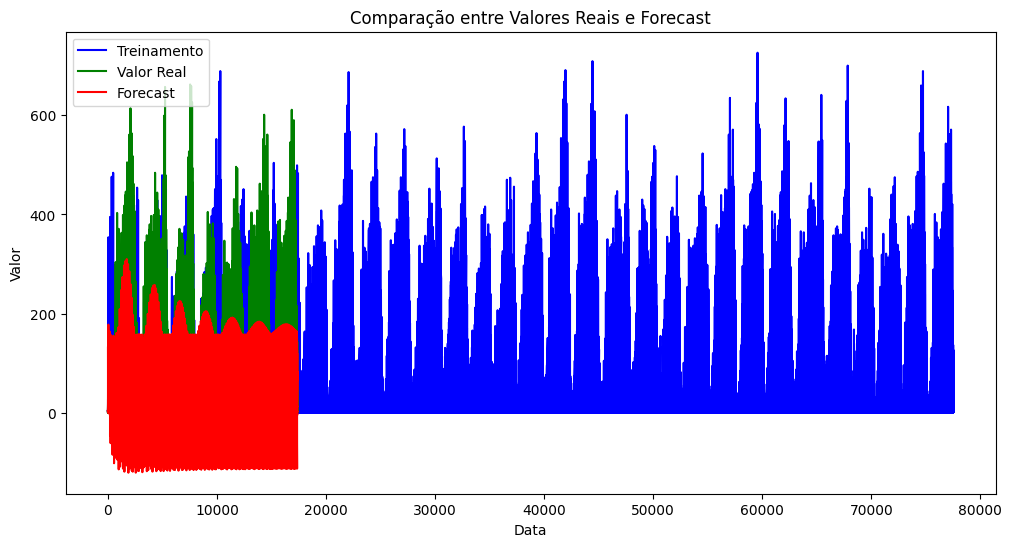

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(df_train_no_lag.index, df_train_no_lag['qty_travels'], label='Treinamento', color='blue')
plt.plot(df_valid_no_lag.index, df_valid_no_lag['qty_travels'], label='Valor Real', color='green')
plt.plot(df_valid_no_lag.index, tm.predict(df_valid_no_lag), label='Forecast', color='red')
plt.legend(loc='upper left')
plt.title('Comparação entre Valores Reais e Forecast')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [45]:
#Quebrar por hora e região
# usar last 3 hours como feature
# comparar com média e desvio padrão
# Gerar boxplots

# Evaluate

In [ ]:
R² e map

get_metrics([
        (clf, clf.feature_names_in_, 'no lag features', df_train_lag, df_valid_lag),
        (clf_, clf_.feature_names_in_, 'with lag features', df_train_lag, df_valid_lag),
        (clf_2, clf_2.feature_names_in_, 'no lag features', df_train_lag, df_valid_lag),
        (clf_2_, clf_2_.feature_names_in_, 'with lag features', df_train_lag, df_valid_lag),
        (tm_arima, ['year_month_day_hour', 'PULocationID', 'qty_travels'], 'arima with one trend', df_train_no_lag, df_valid_no_lag)
    ],
    df_train_lag,
    df_valid_lag,
    'qty_travels'
)

model  \
0                                            Default   
1           <class 'lightgbm.sklearn.LGBMRegressor'>   
2           <class 'lightgbm.sklearn.LGBMRegressor'>   
3  <class 'sklearn.tree._classes.DecisionTreeRegr...   
4  <class 'sklearn.tree._classes.DecisionTreeRegr...   
5                   <class '__main__.TemporalModel'>   

                        desc      rmse_train      rmse_valid  diff_rmse  
0  Default values mean + std  38.24 +- 70.38  40.76 +- 73.29   0.000000  
1            no lag features       45.566266       48.036095  -2.469830  
2          with lag features       38.462266       41.787894  -3.325627  
3            no lag features       23.939122       47.109104 -23.169983  
4          with lag features       33.309251       42.176222  -8.866971  
5       arima with one trend       67.815639        69.98416  -2.168521

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df_valid_lag['predict_travels_lgbm_no_lag'] = clf.predict(df_valid_lag[clf.feature_names_in_])
df_valid_lag['predict_travels_lgbm_lag'] = clf_.predict(df_valid_lag[clf_.feature_names_in_])
df_valid_lag['predict_travels_tree_no_lag'] = clf_2.predict(df_valid_lag[clf_2.feature_names_in_])
df_valid_lag['predict_travels_tree_lag'] = clf_2_.predict(df_valid_lag[clf_2_.feature_names_in_])

In [ ]:
df_valid_lag['error_lgbm_no_lag'] = abs(df_valid_lag['qty_travels'] - df_valid_lag['predict_travels_lgbm_no_lag'])
df_valid_lag['error_lgbm_lag'] = abs(df_valid_lag['qty_travels'] - df_valid_lag['predict_travels_lgbm_lag'])
df_valid_lag['error_tree_no_lag'] = abs(df_valid_lag['qty_travels'] - df_valid_lag['predict_travels_tree_no_lag'])
df_valid_lag['error_tree_lag'] = abs(df_valid_lag['qty_travels'] - df_valid_lag['predict_travels_tree_lag'])

In [ ]:
df_melted = pd.melt(
    df_valid_lag, 
    id_vars='PULocationID', 
    value_vars=['qty_travels', 'predict_travels_lgbm_no_lag', 
                'predict_travels_lgbm_lag', 'predict_travels_tree_no_lag',
                'predict_travels_tree_lag'], 
    var_name='Tipo', 
    value_name='Valor'
)

In [ ]:
group_values = df_valid_lag.groupby(['PULocationID']).agg({'qty_travels':['median', 'count']}).sort_values(by=('qty_travels', 'count'), ascending=False)
grupos_unicos = group_values.index
num_grupos = len(grupos_unicos)
num_cols = 4
num_rows = (num_grupos + num_cols - 1) // num_cols

# Configurar a figura e os eixos
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, num_rows * 5))
axes = axes.flatten()

# Plotar cada grupo em um subplot
for i, grupo in enumerate(grupos_unicos):
    ax = axes[i]
    dados_grupo = df_melted[df_melted['PULocationID'] == grupo]

    sns.boxplot(
        data=dados_grupo,
        x='Tipo', y='Valor',
        ax=ax,
        hue='Tipo',
        showfliers=False,
        legend=True
    )

    y_min = dados_grupo['Valor'].min() - 20
    y_max = dados_grupo['Valor'].max() + 20
    ax.set_ylim(y_min, y_max)
    ax.legend(loc='upper right', frameon=True)
    ax.set_xticklabels([])

    qty_valid = group_values[group_values.index == grupo].loc[:,('qty_travels', 'count')].values[0]
    rmse_valid = round(root_mean_squared_error(dados_grupo[(dados_grupo['Tipo'] == 'qty_travels')]['Valor'],
                                         dados_grupo[(dados_grupo['Tipo'] == 'predict_travels_lgbm_lag')]['Valor']), 2)
    mean = round(dados_grupo[(dados_grupo['Tipo'] == 'qty_travels')]['Valor'].mean(),2)
    std = round(dados_grupo[(dados_grupo['Tipo'] == 'qty_travels')]['Valor'].std(),2)
    ax.set_title(f'Grupo {grupo} - Qty. Valid: {qty_valid}\nRMSE: {rmse_valid} Mean: {mean} Std: {std}')
    ax.set_xlabel('')
    ax.set_ylabel('Valor')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
# Boxplot total e media nos boxplot

In [ ]:
metrics_location = df_valid_lag.groupby('PULocationID').agg({
    'qty_travels' : ['count', 'mean', 'median', 'std'],
    'predict_travels' : ['mean', 'median', 'std'],
    'error' : ['mean', 'median', 'std']
}).reset_index()

metrics_location.columns = metrics_location.columns = ['PULocationID', 'qty_obs', 'travels_mean', 'travels_median', 'travels_std',
                                                       'predict_mean', 'predict_median', 'predict_std',
                                                       'error_mean', 'error_median', 'erros_std']

In [ ]:
metrics_location.head()

PULocationID  qty_obs  travels_mean  travels_median  travels_std  \
0             1       31      3.193548             3.0     2.182038   
1             3       19      2.736842             2.0     1.995609   
2             4      143      2.349650             2.0     2.314251   
3             6        4      1.750000             2.0     0.500000   
4             7      132      3.136364             2.0     5.961419   

   predict_mean  predict_median  predict_std  error_mean  error_median  \
0      8.324335        7.999383     2.630515    5.237195      5.312850   
1      9.604308        8.780110     2.925265    7.277386      6.780110   
2      4.852824        4.373960     1.992451    3.017624      2.443242   
3     12.555056       12.845554     2.002044   10.805056     11.345554   
4      5.779462        4.478085     4.660604    4.567835      3.143450   

   erros_std  
0   2.576243  
1   2.991094  
2   2.504042  
3   1.876844  
4   6.629363

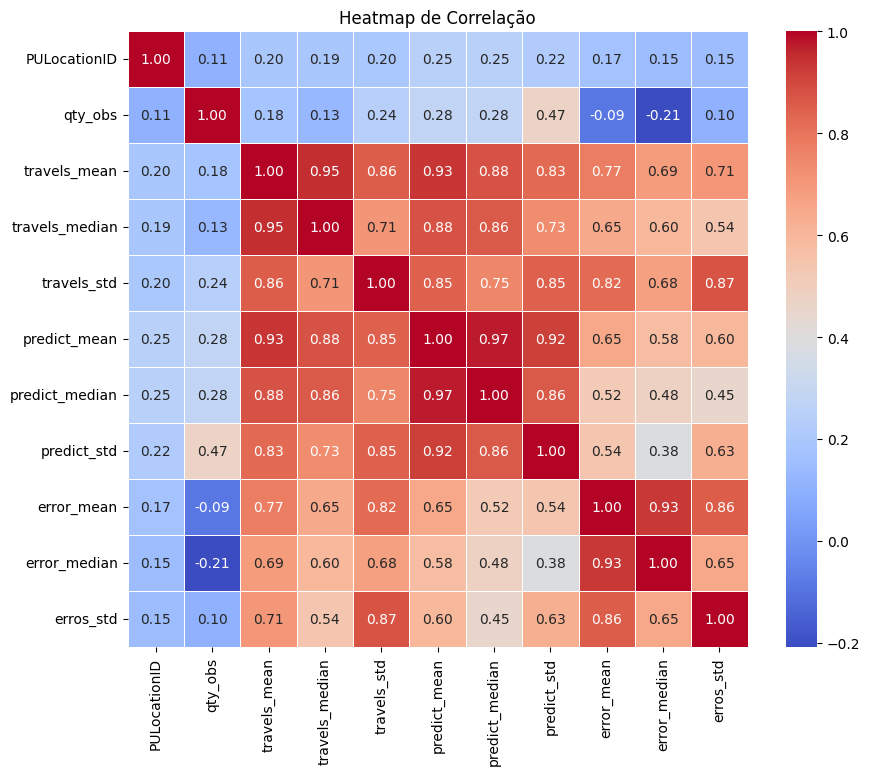

In [ ]:
plt.figure(figsize=(10, 8))

sns.heatmap(metrics_location.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap de Correlação")
plt.show()